## Modules

In [489]:
import os
from tqdm import tqdm

import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, correlate, butter, freqs, filtfilt, resample
from scipy.ndimage import gaussian_filter, median_filter
from scipy.stats import sem
from signal_analysis import SignalAnalysis
from scipy.optimize import curve_fit

import seaborn as sns
import seaborn_image as isns
import cmcrameri.cm as cmc
from matplotlib import pyplot as plt


cmap = 'cmc.batlow'
# sns.set_palette(cmap)

## Analysis Functions

In [442]:
def lowpassFilter(data:list, cutoff:float, fs:float=10, order:int=5)->list:
    """lowpass filter easy to use for data

    Args:
        data (list): 1D array of data (timeseries)
        cutoff (float): cutoff frequency
        fs (float, optional): sampling frequency. Defaults to 10.
        order (int, optional): order of the butter filter. Defaults to 5.

    Returns:
        list: filtered data
    """
    nyq = 0.5 * fs
    low = cutoff / nyq
    b, a = butter(order, low, btype='low')
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

def prepData(sig:list, time:list, filter=False)-> list:
    """Prepares raw data to calculate HbO and HbR: removes 
        drift if any, and normalizes around 1

    Args:
        sig (list): 1D array containing signal
        time (list): 1D array containing time
        
    Returns:
        list: returns only the signal in a 1D array. Time is the same.
    """

    def droite(x, a, b):
        return a*x + b

    popt, pcov = curve_fit(droite, time, sig)
    sig_n = sig/droite(time, *popt)

    if filter:
        sig_f = lowpassFilter(sig_n, cutoff=0.2)

    else:
        sig_f = sig_n

    return sig_f


def absorptionCoefficientVariation(intensity:list, wavelength:int=530, dim:int=3) -> list:
    """Calculates the absorption coefficient variation for a specific wavelength

    Args:
        intensity (list): light signal over time
        wavelength (int, optional): wavelength of light, either 530 or 625 nm. Defaults to 530.
        dim (int, optional): dimension of data. Defaults to 3.

    Returns:
        list: variation of mu_a coefficient over time
    """
    if wavelength == 530:
        X = 0.371713e-3            # m
    elif wavelength == 625:
        X = 3.647821e-3            # m
    else:
        print('Wrong wavelength input: 530 or 625 only')
        return None
    
    if dim == 3:
        iniIntens = intensity[:,:,0][..., np.newaxis]
        iniIntens[np.where(iniIntens == 0)] = 1
        mu = (-1/X)* np.log(intensity/iniIntens)

    elif dim == 2:
        iniIntens = intensity[:,0][..., np.newaxis]
        iniIntens[np.where(iniIntens == 0)] = 1
        mu = (-1/X)* np.log(intensity/iniIntens)

    elif dim == 1:
        iniIntens = intensity[0][..., np.newaxis]
        iniIntens[np.where(iniIntens == 0)] = 1
        mu = (-1/X)* np.log(intensity/iniIntens)

    # np.where(iniIntens == 0, 1, iniIntens)
    # print(np.shape(iniIntens))
    # with open('iniIntens{}.txt'.format(wavelength), 'w') as outfile:
    #     for dataslice in iniIntens:
    #         np.savetxt(outfile, dataslice)
    return mu

def oxygenation(greenData: list, redData: list, dim:int=3) -> tuple:
    """Generates a tuple that contains the variation of HbO and HbR concentrations over time

    Args:
        greenData (list): 530 nm absorption coefficient evolution in time
        redData (list): 625 nm absorption coefficient evolution in time
        dim (int, optional): _description_. Defaults to 3.

    Returns:
        tuple: variation of HbR and HbO over time (delta c_HbR, delta c_HbO)
    """

    mu_530 = absorptionCoefficientVariation(greenData, 530, dim)
    mu_625 = absorptionCoefficientVariation(redData, 625, dim)

    eHbO_530 = 39956.8e2      # m-1 M-1
    eHbR_530 = 39036.4e2
    eHbO_625 = 740.8e2
    eHbR_625 = 5763.4e2

    dc_HbR = (eHbO_530*mu_625 - eHbO_625*mu_530)/(eHbO_530*eHbR_625 + eHbO_625*eHbR_530)
    dc_HbO = (eHbR_530*mu_625 - eHbR_625*mu_530)/(eHbR_530*eHbO_625 + eHbR_625*eHbO_530)

    return (dc_HbR, dc_HbO)

## Open data

In [407]:
pathBase = r"C:\Users\gabri\Desktop\testAnalyse\2024_07_18"

green = np.loadtxt(pathBase + "\\csv\\530.csv", skiprows=1, delimiter=',')[:,1]
red = np.loadtxt(pathBase + "\\csv\\625.csv", skiprows=1, delimiter=',')[:,1]

green_t = np.load(pathBase + "\\530ts.npy")
red_t = np.load(pathBase + "\\625ts.npy")

## AP time series

In [311]:
FPS = 50
AP_idx = []
nChannels=5
AP_begin = 5
percycle=15
FPSc = FPS/nChannels
framespcycles = int(FPSc*percycle)
ncycles = int(len(green_t)//framespcycles)
AP_times = np.array(list(range(ncycles)))*15+5

for ti in AP_times:
    AP_idx.append(np.argmin(np.absolute(green_t-ti)))

# Dirac où AP dans times series
AP_series = np.zeros(len(green_t))
AP_series[AP_idx] = 1

## Quick plot

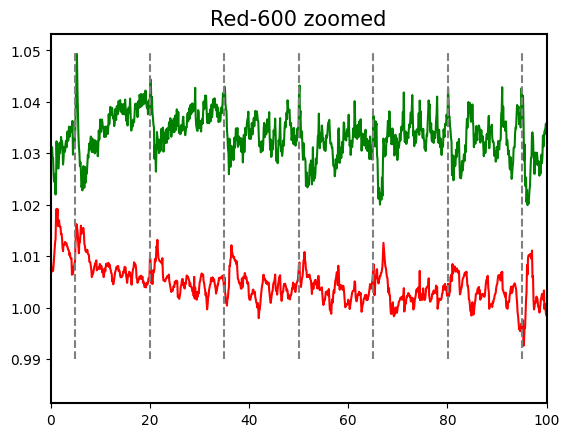

In [382]:
plt.plot(red_t, red/np.mean(red), 'r-')
plt.plot(green_t, green/np.mean(green)+0.03, 'g-')
plt.vlines(red_t[AP_idx], 0.99, 1.05, colors='grey', linestyles='--')
plt.xlim(0, 100)
# plt.savefig('red_600zoomed.png', dpi=600)

## Function testing

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\gabri\AppData\Local\Temp\ipykernel_1880\3301314219.py:13: SyntaxWarning: invalid escape sequence '\s'
  FBH530 = np.loadtxt("analysisPipeline\specs sys optique\FBH530-10.csv", skiprows=1, usecols=(0, 2), delimiter=';')


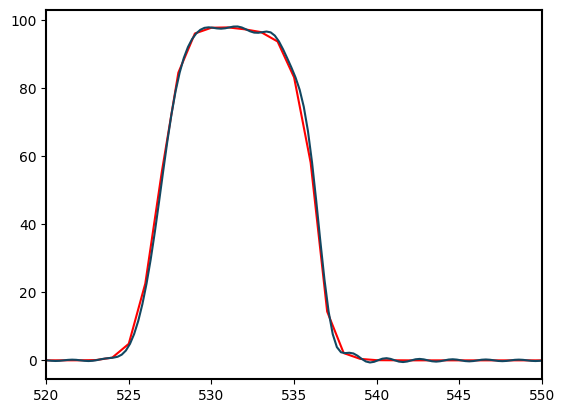

In [494]:
def convertToHb():
    pass

# c_camera
os.chdir(r"C:\Users\gabri\Documents\Université\Maitrise\Projet\Widefield-Imaging-Acquisition")
# QE_moment = np.loadtxt("analysisPipeline\specs sys optique\QE_moment_5px.csv", delimiter=';')
# p = np.poly1d(np.polyfit(QE_moment[:,0], QE_moment[:,1], 10))
wl = np.linspace(450, 700, 1000)
# c_camera = p(wl)/np.max(p(wl))
# plt.plot(wl, c_camera)

# c_lec
FBH530 = np.loadtxt("analysisPipeline\specs sys optique\FBH530-10.csv", skiprows=1, usecols=(0, 2), delimiter=';')
FBH530_wl = FBH530[:,0]
# FBH530_trans = FBH530[:,1]
idx_min = np.argmin(np.abs(FBH530_wl-450))
idx_max = np.argmin(np.abs(FBH530_wl-700))
FBH530_wl = FBH530_wl[idx_min:idx_max]
FBH530_trans = FBH530[idx_min:idx_max, 1]
plt.plot(FBH530_wl, FBH530_trans, 'r-')
# print(len(FBH530_trans))
f = resample(FBH530_trans, 1000)
plt.plot(wl, f)
plt.xlim(520, 550)

# plt.xlim(450, 700)
# p = np.poly1d(np.polyfit(FBH530[:,0], FBH530[:,1], 10))
# plt.plot(wl, p(wl))




test = False
if test:
    preped_data = prepData(green, green_t, filter=False)
    filtered_data = prepData(green, green_t, filter=True)
    plt.plot(red_t, preped_data, color='lightgrey')
    plt.plot(red_t, filtered_data)

## Coefficient d'absorption

(10.0, 50.0)

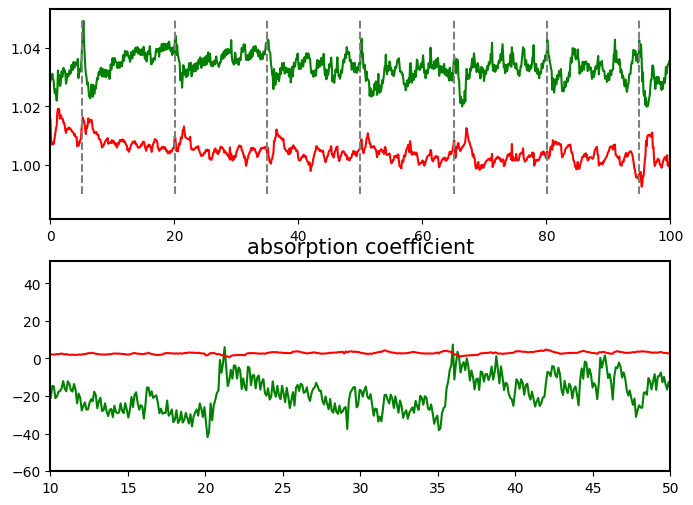

In [384]:
mu_green = absorptionCoefficientVariation(green/np.mean(green), wavelength=530, dim=1)
mu_red = absorptionCoefficientVariation(red/np.mean(red), wavelength=625, dim=1)

# mu_green = np.nan_to_num(mu_green, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
# mu_red = np.nan_to_num(mu_red, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
# print(np.min(mu_green), np.max(mu_green))
# print(np.min(mu_red), np.max(mu_red))

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(2, 1, 1)
plt.plot(red_t, red/np.mean(red), 'r-')
plt.plot(green_t, green/np.mean(green)+0.03, 'g-')
plt.vlines(red_t[AP_idx], 0.99, 1.05, colors='grey', linestyles='--')
plt.xlim(0, 100)
# plt.vlines(green_t[AP_idx], np.min(green), np.max(green))
# plt.xlim(10, 50)

ax2 = plt.subplot(2, 1, 2)
plt.plot(green_t, mu_green, 'g-')
plt.plot(red_t, mu_red, 'r-')
ax2.set_title('absorption coefficient')
plt.xlim(10, 50)
# plt.vlines(green_t[AP_idx], np.min(mu_green), np.max(mu_green))

# plt.savefig('absorptioncoeff.png', dpi=600)

## HbO HbR

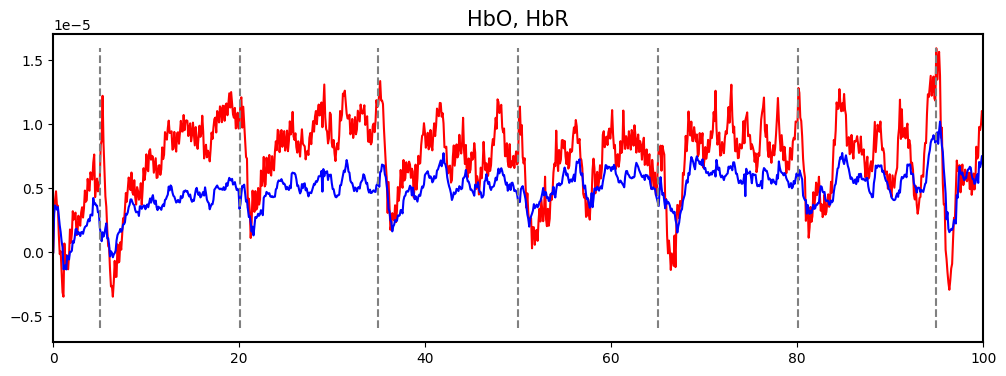

In [385]:
HbR, HbO = oxygenation(green/np.mean(green), red/np.mean(red), dim=1)

fig = plt.figure(figsize=(12, 4))
plt.plot(red_t, HbO, 'r-')
plt.plot(red_t, HbR, 'b-')
# plt.plot(red_t, AP_series, color='grey')
plt.vlines(red_t[AP_idx], np.min(HbO), np.max(HbO), color='grey', linestyles='--')
# plt.ylim(np.min(HbO), np.max(HbO))
plt.xlim(0, 100)
plt.title('HbO, HbR')
plt.savefig('hbohbr.png', dpi=600)


## Correlation avec HbO HbR

lag: 1.3 s
lag: 1.6 s


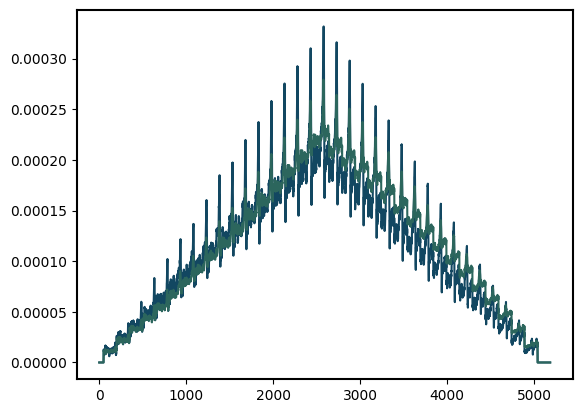

In [348]:
correlation = correlate(AP_series, HbO*-1+2e-5)
lag = np.argmax(correlation)
print('lag:', (len(red_t) - lag)*1/10, 's')
plt.plot(correlation)
correlation = correlate(AP_series, HbR*-1+2e-5)
lag = np.argmax(correlation)
print('lag:', (len(red_t) - lag)*1/10, 's')
plt.plot(correlation)